In [1]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils

BDC is using numpy


In [2]:
#define some basic functions here, like xcorr and etc

@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr


<h1 style="font-size:30pt">Setup</h1>

Start with basic hard-coded stuff (to make config later)

In [3]:

#spectrum interval (aka period) (4096 point FFT, 250M sampling rate)
T_SPECTRA = 4096/250e6

#start and end times
start_file_time = 1721800002
t_start = start_file_time  #for easy correlation purposes
t_end = t_start + 1000

#set integration times for coarse and visibilities (spectra per chunk)
c_acclen = 10**6 
acclen = 30* 10**3 
print(c_acclen, acclen)

#time taken for one full chunk 
T_ACCLEN_C = c_acclen* T_SPECTRA
T_ACCLEN_V = acclen* T_SPECTRA
#how many total chunks for the time interval we care about
nchunks_c = int((t_end-t_start)/T_ACCLEN_C)
nchunks_v = int((t_end-t_start)/T_ACCLEN_V)


#use "get_init_info" to get the files and spectrum numbers needed for our time interval
a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"
files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)
print(files_a1)
print(files_a2)
print("Uncorrected Starting Indices:", idx1, idx2)
print("Initial Offset:", idx1-idx2)


#get channel indices between 1834 and 1854, where we think we will find satellites
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
#total number of channels
nchans=chanend-chanstart 

1000000 30000
['/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800002.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800047.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800091.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800135.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800180.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800224.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800269.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800313.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800357.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800402.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800446.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800490.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800535.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/

Here is the List of passes:

In [125]:
passes = [[[143, 222], [3]], [[990, 1054], [1]], [[1400, 1429], [3]], [[1723, 1794], [0]], [[2195, 2288], [1]], [[2926, 3022], [0]], [[3401, 3506], [1]]]

for i in range(len(passes)):
    passes[i][0] = (np.array(passes[i][0]) * 5).tolist()

print(passes)

for i in range(len(passes)):
    print(f"Pass {i} in seconds offset:", passes[i][0])

time_offsets = [ p[0][0]+40 for p in passes]
print(time_offsets)


[[[715, 1110], [3]], [[4950, 5270], [1]], [[7000, 7145], [3]], [[8615, 8970], [0]], [[10975, 11440], [1]], [[14630, 15110], [0]], [[17005, 17530], [1]]]
Pass 0 in seconds offset: [715, 1110]
Pass 1 in seconds offset: [4950, 5270]
Pass 2 in seconds offset: [7000, 7145]
Pass 3 in seconds offset: [8615, 8970]
Pass 4 in seconds offset: [10975, 11440]
Pass 5 in seconds offset: [14630, 15110]
Pass 6 in seconds offset: [17005, 17530]
[755, 4990, 7040, 8655, 11015, 14670, 17045]


<h1 style="font-size:30pt">CxCorr Stuff</h1>

Start by opening the file for uncorrected offset. We set up the offset times to make sure that we get a starting chunk which is inside a satellite pass. Both are two hours long, so we should have two distinct 

Set up individual passes.

In [130]:
pulse_idx = 6

t_start_pulse, t_end_pulse = t_start + time_offsets[pulse_idx], t_end + time_offsets[pulse_idx]

files_a1_pulse, idx1_pulse = butils.get_init_info(t_start_pulse, t_end_pulse, a1_path)
files_a2_pulse, idx2_pulse = butils.get_init_info(t_start_pulse, t_end_pulse, a2_path)

ant1_pulse = bdc.BasebandFileIterator(files_a1_pulse, 0, idx1_pulse, c_acclen, nchunks=nchunks_c, chanstart=chanstart, chanend=chanend, type='float')
ant2_pulse = bdc.BasebandFileIterator(files_a2_pulse, 0, idx2_pulse, c_acclen, nchunks=nchunks_c, chanstart=chanstart, chanend=chanend, type='float')


ACCLEN RECEIVED IS 1000000
took 1.378 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721817046.raw
START SPECNUM IS 2030100249 obj start at 2030039214
ACCLEN RECEIVED IS 1000000
took 1.351 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721817018.raw
START SPECNUM IS 2086330477 obj start at 2084560457


In [131]:
p0_a1_pulse = np.zeros((c_acclen, nchans), dtype="complex128")
p0_a2_pulse = np.zeros((c_acclen, nchans), dtype="complex128")
a1_c_start = ant1_pulse.spec_num_start
print(a1_c_start)
a2_c_start = ant2_pulse.spec_num_start
for i, (chunk1, chunk2) in enumerate(zip(ant1_pulse, ant2_pulse)):
        perc_missing_a1 = (1 - len(chunk1["specnums"]) / c_acclen) * 100
        perc_missing_a2 = (1 - len(chunk2["specnums"]) / c_acclen) * 100
        print("missing a1", perc_missing_a1, "missing a2", perc_missing_a2)
        if perc_missing_a1 > 10 or perc_missing_a2 > 10:
            a1_c_start = ant1_pulse.spec_num_start
            a2_c_start = ant2_cpulse.spec_num_start
            print("skipping")
            continue
        print(chunk1["specnums"] - a1_c_start)
        outils.make_continuous(
            p0_a1_pulse, chunk1["pol0"], chunk1["specnums"] - a1_c_start
        )
        outils.make_continuous(
            p0_a2_pulse, chunk2["pol0"], chunk2["specnums"] - a2_c_start
        )
        break

2030100249
took 1.429 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721817062.raw
missing a1 0.0 missing a2 0.0
[     0      1      2 ... 999997 999998 999999]


In [132]:
xc=np.fft.fftshift(get_coarse_xcorr(p0_a1_pulse,p0_a2_pulse),axes=1)

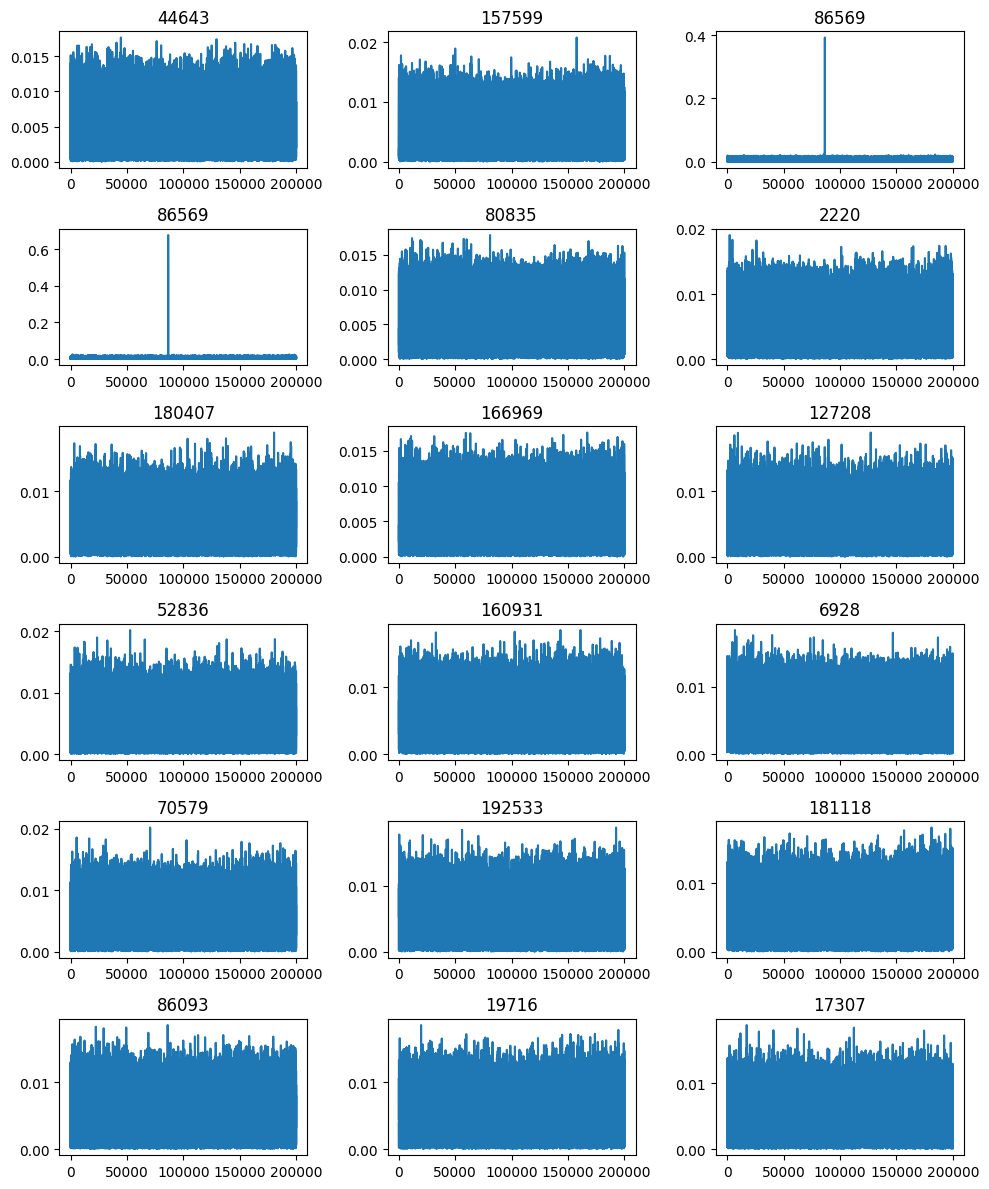

In [133]:
center= c_acclen
dN= 100000
fig,ax=plt.subplots(6,3)
fig.set_size_inches(10,12)
ax=ax.flatten()
for cc in range(nchans):
    mm=np.argmax(np.abs(xc[cc,center-dN:center+dN]))
    ax[cc].set_title(f"{mm}")
    ax[cc].plot(np.abs(xc[cc,center-dN:center+dN]))
plt.tight_layout()

Let's investigate an American Satellite, e.g. the one in pulse of index 2. It appears that if you shift the time at which you correlate the chunk, that it is an UNRELIABLE offset, i.e. it changes. What does that mean, and geometrically how does this come about? Well, let's see.

In [134]:

pass_2 = passes[pulse_idx][0]
start_2 = int(pass_2[0])
stop_2 = int(pass_2[1])
pass_2_duration = stop_2 - start_2

offsets = my_list = list(range(int(start_2), int(stop_2), 20))
print(offsets)

[17005, 17025, 17045, 17065, 17085, 17105, 17125, 17145, 17165, 17185, 17205, 17225, 17245, 17265, 17285, 17305, 17325, 17345, 17365, 17385, 17405, 17425, 17445, 17465, 17485, 17505, 17525]


In [135]:
offsets_measured = []
average_discrepancy = []

for k in range(len(offsets)):
    print(f"-------Iteration {k}-------") 
    print("Working with this offset:", offsets[k])

    t_start_pulse, t_end_pulse = t_start + offsets[k], t_end + offsets[k]

    files_a1_pulse, idx1_pulse = butils.get_init_info(t_start_pulse, t_end_pulse, a1_path)
    files_a2_pulse, idx2_pulse = butils.get_init_info(t_start_pulse, t_end_pulse, a2_path)

    ant1_pulse = bdc.BasebandFileIterator(files_a1_pulse, 0, idx1_pulse, c_acclen, nchunks=nchunks_c, chanstart=chanstart, chanend=chanend, type='float')
    ant2_pulse = bdc.BasebandFileIterator(files_a2_pulse, 0, idx2_pulse, c_acclen, nchunks=nchunks_c, chanstart=chanstart, chanend=chanend, type='float')


    p0_a1_pulse = np.zeros((c_acclen, nchans), dtype="complex128")
    p0_a2_pulse = np.zeros((c_acclen, nchans), dtype="complex128")
    a1_c_start = ant1_pulse.spec_num_start
    print(a1_c_start)
    a2_c_start = ant2_pulse.spec_num_start
    for i, (chunk1, chunk2) in enumerate(zip(ant1_pulse, ant2_pulse)):
        perc_missing_a1 = (1 - len(chunk1["specnums"]) / c_acclen) * 100
        perc_missing_a2 = (1 - len(chunk2["specnums"]) / c_acclen) * 100
        print("missing a1", perc_missing_a1, "missing a2", perc_missing_a2)
        if perc_missing_a1 > 10 or perc_missing_a2 > 10:
            a1_c_start = ant1_pulse.spec_num_start
            a2_c_start = ant2_cpulse.spec_num_start
            print("skipping")
            continue
        print(chunk1["specnums"] - a1_c_start)
        outils.make_continuous(
            p0_a1_pulse, chunk1["pol0"], chunk1["specnums"] - a1_c_start
        )
        outils.make_continuous(
            p0_a2_pulse, chunk2["pol0"], chunk2["specnums"] - a2_c_start
        )
        break

    xc=np.fft.fftshift(get_coarse_xcorr(p0_a1_pulse,p0_a2_pulse),axes=1)

    center= c_acclen
    dN= 100000
    max2=np.argmax(np.abs(xc[2,center-dN:center+dN]))
    max3=np.argmax(np.abs(xc[3,center-dN:center+dN]))
    
    print("Difference in Offset:", max2-max3)
    average_discrepancy.append(max2-max3)
    print("Average Offset:", (max2+max3)/2)
    offsets_measured.append((max2+max3)/2)

print("done")


-------Iteration 0-------
Working with this offset: 17005
ACCLEN RECEIVED IS 1000000
took 1.562 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721817001.raw
START SPECNUM IS 2027696453 obj start at 2027330242
ACCLEN RECEIVED IS 1000000
took 1.392 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721816973.raw
START SPECNUM IS 2083926680 obj start at 2081851485
2027696453
took 0.270 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721817018.raw
missing a1 0.0 missing a2 0.0
[     0      1      2 ... 999997 999998 999999]
Difference in Offset: 0
Average Offset: 86568.0
-------Iteration 1-------
Working with this offset: 17025
ACCLEN RECEIVED IS 1000000
took 0.270 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721817001.raw
START SPECNUM IS 2028917156 obj start at 2027330242
ACCLEN RECEIVED IS 1000000
took 0.170 seconds to read raw data on  /scratc

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

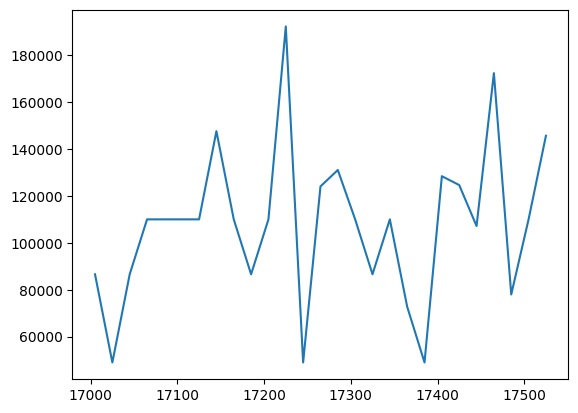

In [140]:
plt.plot(offsets, offsets_measured)


for i in range(len(offsets_measured)):
    offsets_measured[i] = int(offsets_measured)
print(offsets_measured)
print(average_discrepancy)

Difference in Offset: 157537
Average Offset: 118847.5


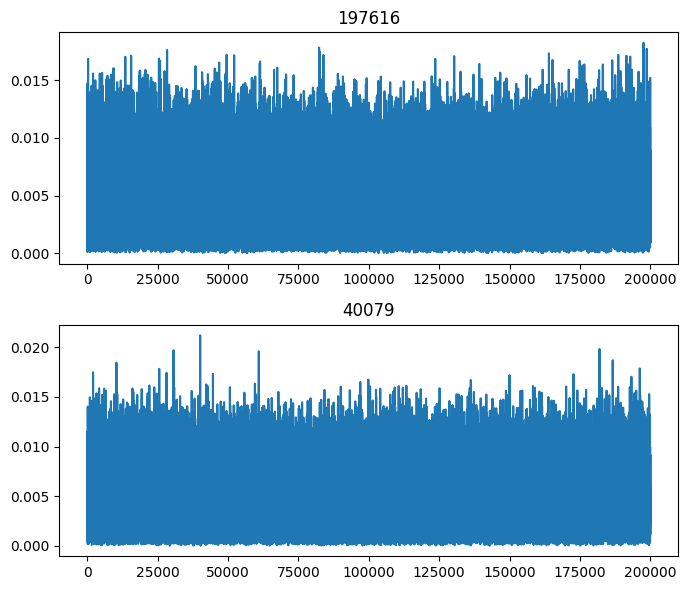

In [ ]:
center= c_acclen
dN= 100000
fig,ax=plt.subplots(2)
fig.set_size_inches(7,6)
ax=ax.flatten()

max2=np.argmax(np.abs(xc[2,center-dN:center+dN]))
ax[0].set_title(f"{max2}")
ax[0].plot(np.abs(xc[2,center-dN:center+dN]))

max3=np.argmax(np.abs(xc[3,center-dN:center+dN]))
ax[1].set_title(f"{max3}")
ax[1].plot(np.abs(xc[3,center-dN:center+dN]))

plt.tight_layout()

print("Difference in Offset:", max2-max3)
print("Average Offset:", (max2+max3)/2)

<h1 style="font-size:30pt">Satellite Stuff</h1>

Below is where I would run the satellite_detection script, and get both the SPEC OFFSET and the PULSES, needed for the next step. For now it's bullshit plot armour hand-waving.

In [ ]:
idx_correction=109993-100000
if idx_correction>0:
    idx1_corrected = idx1+idx_correction
else:
    idx2_corrected = idx2+np.abs(idx_correction)
print("Corrected Starting Indices:", idx1_corrected, idx2_corrected)

Corrected Starting Indices: 2085188 1098633


<h1 style="font-size:30pt">Visibility Stuff</h1>

Now, once we have the predicted phase and have the index offset set up, we can find the observed phases. Recall that for now, this is only done for ONE satellite pass. We want to get to at least five passes, so in the streamlined code this will be done recursively.

In [ ]:
#set up BaseBandFileIterator objects for both antenna
#this should be with the CORRECTED starting index though.

ant1_v = bdc.BasebandFileIterator(files_a1, 0, idx1_corrected, v_acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')
ant2_v = bdc.BasebandFileIterator(files_a2, 0, idx2_corrected, v_acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')

ACCLEN RECEIVED IS 30000
took 0.235 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800668.raw
START SPECNUM IS 1032513734 obj start at 1030428546
ACCLEN RECEIVED IS 30000
took 1.422 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721800684.raw
START SPECNUM IS 1088757394 obj start at 1087658761


In [ ]:
#the chunk-by-chunk reading method. make sure that not too much data is missing
p0_a1 = np.zeros((acclen, nchans), dtype="complex128") #remember that BDC returns complex64. wanna do phase-centering in 128.
p0_a2 = np.zeros((acclen, nchans), dtype="complex128")
a1_start = ant1.spec_num_start
a2_start = ant2.spec_num_start
for i, (chunk1, chunk2) in enumerate(zip(ant1, ant2)):
    perc_missing_a1 = (1 - len(chunk1["specnums"]) / acclen) * 100
    perc_missing_a2 = (1 - len(chunk2["specnums"]) / acclen) * 100
    print("missing a1", perc_missing_a1, "missing a2", perc_missing_a2)
    if perc_missing_a1 > 10 or perc_missing_a2 > 10:
        a1_start = ant1.spec_num_start
        a2_start = ant2.spec_num_start
        print("skipping")
        continue
    print(chunk1["specnums"] - a1_start)
    outils.make_continuous(
        p0_a1, chunk1["pol0"], chunk1["specnums"] - a1_start
    )
    outils.make_continuous(
        p0_a2, chunk2["pol0"], chunk2["specnums"] - a2_start
    )
    break

missing a1 0.0 missing a2 0.0
[    0     1     2 ... 29997 29998 29999]


In [ ]:
#getting visibility

m1=ant1.spec_num_start
m2=ant2.spec_num_start
visibility_phased = np.zeros((nchunks,len(ant1.channel_idxs)), dtype='complex64')
st=time.time()
        
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
        # pol00[i,:] = cr.avg_xcorr_4bit_2ant(chunk1['pol0'], chunk2['pol0'],chnk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        xcorr=avg_xcorr_4bit_2ant_float(
                chunk1['pol0'], 
                chunk2['pol0'],
                chunk1['specnums'],
                chunk2['specnums'],
                m1+i*acclen,
                m2+i*acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/acclen
        print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)


CHUNK 0  has  30000  rows
CHUNK 1  has  30000  rows
CHUNK 2  has  30000  rows
CHUNK 3  has  30000  rows
CHUNK 4  has  30000  rows
CHUNK 5  has  30000  rows
CHUNK 6  has  30000  rows
CHUNK 7  has  30000  rows
CHUNK 8  has  30000  rows
CHUNK 9  has  30000  rows
CHUNK 10  has  30000  rows
CHUNK 11  has  30000  rows
CHUNK 12  has  30000  rows
CHUNK 13  has  30000  rows
CHUNK 14  has  30000  rows
CHUNK 15  has  30000  rows
CHUNK 16  has  30000  rows
CHUNK 17  has  30000  rows
CHUNK 18  has  30000  rows
took 1.405 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800712.raw
CHUNK 19  has  30000  rows
CHUNK 20  has  30000  rows
CHUNK 21  has  30000  rows
CHUNK 22  has  30000  rows
CHUNK 23  has  30000  rows
CHUNK 24  has  30000  rows
CHUNK 25  has  30000  rows
CHUNK 26  has  30000  rows
CHUNK 27  has  30000  rows
CHUNK 28  has  30000  rows
CHUNK 29  has  30000  rows
CHUNK 30  has  30000  rows
CHUNK 31  has  30000  rows
CHUNK 32  has  30000  rows
CHUNK 33  

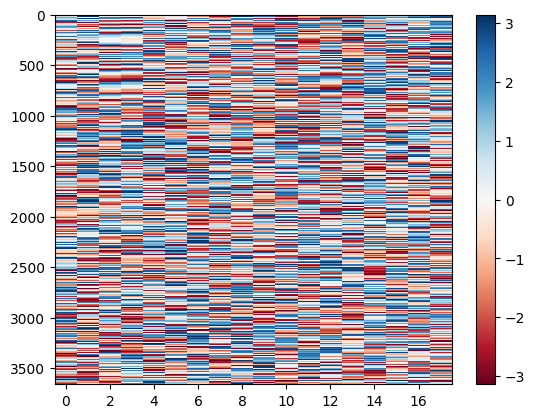

In [ ]:
#plot visibility phase for the whole time
vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

393.216
395


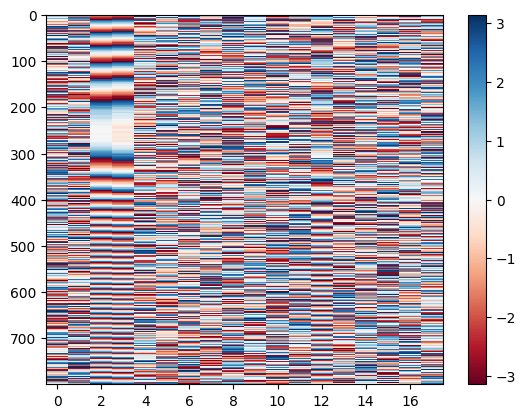

In [ ]:
#for part of the time
isolated_time = 800

vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:isolated_time,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

print(isolated_time*T_ACCLEN)
print((222-143) * 5)

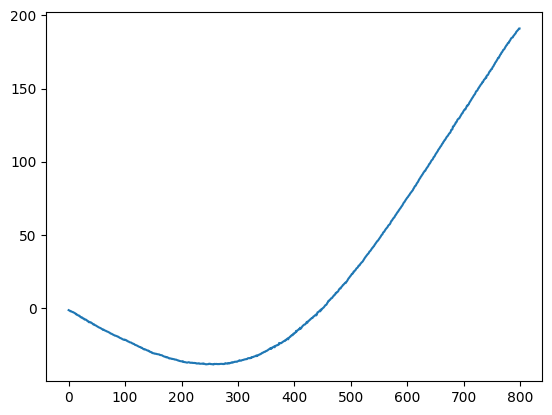

In [ ]:
#plot visibility total

plt.plot(np.unwrap(vis_phase[0:isolated_time,3]))